In [427]:
import numpy as np
import numpy.random

# Моделирование данных датчика
def simulateSensor(samplesCount, noiseSigma, dt):
   # Шум с нормальным распределением. мат. ожидание = 0, среднеквадратичное отклонение = noiseSigma

   sample1 = int(samplesCount/2)
   sample2 = samplesCount - sample1 
   noise1 = numpy.random.normal(loc = 0.0, scale = noiseSigma, size = sample1)
   noise2 = numpy.random.normal(loc = 0.0, scale = noiseSigma, size = sample2)
   noise = np.concatenate([noise1, noise2])
   
   trajectory = np.zeros((3, samplesCount))

   position = 0
   velocity = 1.0
   acceleration = 0.0

   for i in range(1, samplesCount):
       position = position + velocity * dt + (acceleration * dt ** 2) / 2.0
       velocity = velocity + acceleration * dt
       acceleration = acceleration

       trajectory[0][i] = position
       trajectory[1][i] = velocity
       trajectory[2][i] = acceleration

   measurement = trajectory[0] + noise

   return trajectory, measurement # Истинное значение и данные "датчика" с шумом

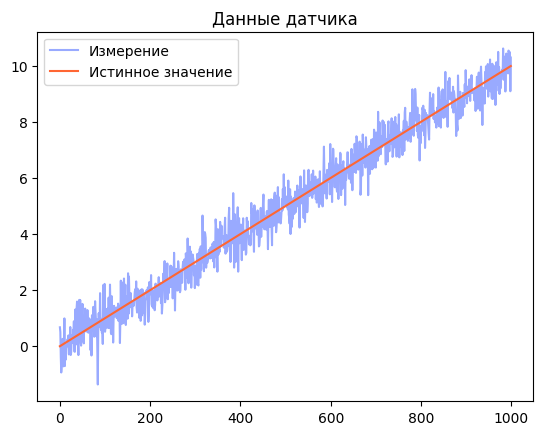

In [428]:
import matplotlib.pyplot as plt
dt = 0.01
measurementSigma = 0.5
trajectory, measurement = simulateSensor(1000, measurementSigma, dt)

plt.title("Данные датчика")
plt.plot(measurement, label="Измерение", color="#99AAFF")
plt.plot(trajectory[0], label="Истинное значение", color="#FF6633")
plt.legend()
plt.show()

In [429]:
import numpy as np
#import filterpy.common

dt = 0.01                       # Шаг времени
measurementSigma = 0.5          # Среднеквадратичное отклонение датчика
processNoise = 1e-4             # Погрешность модели
processNoiseVariance = 1e-4


# F - матрица процесса - размер dim_x на dim_x - 3х3
F = np.array([ [1,   dt,     (dt**2)/2],
                     [0,   1.0,    dt],
                     [0,   0,      1.0]])

# Матрица наблюдения - dim_z на dim_x - 1x3
H = np.array([[1.0, 0.0, 0.0]])



# Ковариационная матрица ошибки модели
#Q = filterpy.common.Q_discrete_white_noise(dim=3, dt=dt, var=processNoiseVariance)
# Q1 = measurementSigma*np.array([[(dt**5)/20.0, dt**4/8, dt**3/6],
#              [dt**4/8, dt**3/3, dt**2/2],
#              [dt**3/6, dt**2/2, dt]])

Q = 100*processNoiseVariance*np.array([[dt**4/4, dt**3/2, dt**2/2],
                                     [dt**3/2, dt**2, dt],
                                     [dt**2/2, dt, 1]])

# Ковариационная матрица ошибки измерения - 1х1
R = 0.0001*np.array([[measurementSigma*measurementSigma]])

# Начальное состояние.
x = np.array([0.0, 0.0, 0.0])

# Ковариационная матрица для начального состояния
P = np.array([[10.0, 0.0,  0.0],
                    [0.0,  10.0, 0.0],
                    [0.0,  0.0,  10.0]])


print(Q)
print(R)

[[2.5e-11 5.0e-09 5.0e-07]
 [5.0e-09 1.0e-06 1.0e-04]
 [5.0e-07 1.0e-04 1.0e-02]]
[[2.5e-05]]


[[0.10003475]]
[[0.10456144]]
[[0.10661347]]
[[0.10912797]]
[[0.11395906]]
[[0.11398755]]
[[0.11654688]]
[[0.11721265]]
[[0.11831656]]
[[0.11901771]]
[[0.12378327]]
[[0.12697705]]
[[0.13275199]]
[[0.13495763]]
[[0.13596113]]
[[0.13591898]]
[[0.1354345]]
[[0.13505456]]
[[0.13424661]]
[[0.1338269]]
[[0.13423659]]
[[0.13342034]]
[[0.13255493]]
[[0.13332705]]
[[0.13447477]]
[[0.13435622]]
[[0.13420386]]
[[0.13346827]]
[[0.13262815]]
[[0.13272994]]
[[0.13186373]]
[[0.1329096]]
[[0.13433249]]
[[0.13481906]]
[[0.13956966]]
[[0.14105886]]
[[0.14336209]]
[[0.14672735]]
[[0.14770275]]
[[0.14936783]]
[[0.15171823]]
[[0.15532414]]
[[0.160433]]
[[0.1645533]]
[[0.17165152]]
[[0.17444607]]
[[0.17826825]]
[[0.18620925]]
[[0.18853641]]
[[0.18968495]]
[[0.19183379]]
[[0.19343222]]
[[0.19446923]]
[[0.19511608]]
[[0.19633563]]
[[0.19648949]]
[[0.19709667]]
[[0.19639303]]
[[0.19630947]]
[[0.19575314]]
[[0.19487727]]
[[0.19459409]]
[[0.19328785]]
[[0.19370321]]
[[0.19235776]]
[[0.19220349]]
[[0.19121416]]
[

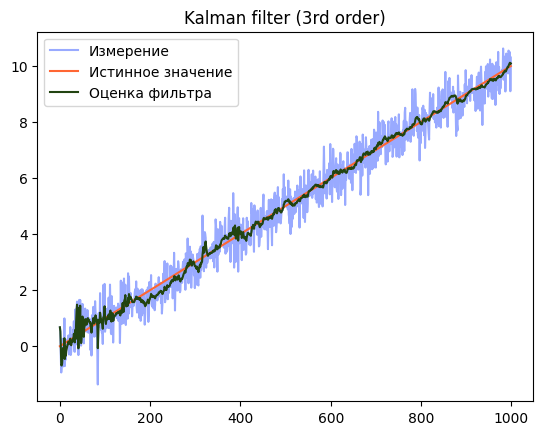

In [430]:
# Классический алгоритм фильтра Калмана 
from numpy.linalg import inv
from numpy import dot, isscalar
filter_state = np.zeros((1000, 3))

alpha = 0.99

for i in range(0, len(measurement)):
    z = measurement[i]
    # predict
    x = dot(F, x)
    P = dot(dot(F, P), F.T) + Q


    y = z - dot(H, x)
    
   
    PHT = dot(P, H.T)
    S = dot(H, PHT) + R
    SI = inv(S)

    K = dot(PHT, SI)
    x = x + dot(K, y)

    eps = z - dot(H, x)
    R = alpha*R + (1-alpha)*(eps*eps.T + H@P@H.T)
    print(R)

    I_KH = np.eye(3) - dot(K, H)
    P = dot(dot(I_KH, P), I_KH.T) + dot(dot(K, R), K.T)

    # RLS adaptation
    Q = (1-alpha)*Q + alpha*((y[0]**2)*K*K.T)
    
    #print((y[0]**2)*K*K.T)

  
    filter_state[i] = x


print(R)
print(Q)
plt.title("Kalman filter (3rd order)")
plt.plot(measurement, label="Измерение", color="#99AAFF")
plt.plot(trajectory[0], label="Истинное значение", color="#FF6633")
plt.plot(filter_state[:, 0], label="Оценка фильтра", color="#224411")
plt.legend()
plt.show()


P = np.array([[10.0, 0.0,  0.0],
                    [0.0,  10.0, 0.0],
                    [0.0,  0.0,  10.0]])

x = np.array([0.0, 0.0, 0.0])
